DSBA-6165 - Project - Stage 3<br>
EDA Notebook<br><br>
Group 2:<br>
<li>Seve Jimenez<br>
<li>Bikash Khadka<br>
<li>Michael Tricanowicz

### Project Change Explanation:

As laid out in our proposal, we had the ambitious goal of working with video data and applying several advanced processing methods as part of the project. We did not have a prepackaged dataset suited to the intended goal of predicting shot placement of penalty kicks. Because of this, we needed to retrieve videos, apply body mapping and pose estimation, or both. These requirements pushed the limits of our technical knowledge as well as the time available for this project. We have spent a significant amount of time trying to implement these processing techniques but have thus far not succeeded. Continuing with the proposed work would require the majority of our time and effort be spent on data preparation, which is not the purpose of this course.<br>
Therefore, we propose to pivot to a new but related scope of work. Sticking with the domain of soccer, we intend to develop models to learn and predict classification of images from in game footage using the dataset outlined in the paper [IAUFD: A 100k images dataset for automatic football image/video analysis](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/ipr2.12543#:~:text=A%20public%20dataset%20was%20collected%2C%20annotated%2C%20and%20prepared%2C,in%202%2C508%20min%2C%20annotated%20in%2010%20event%20categories). This is a dataset of 100,000 images from soccer matches labeled with one or more classes from the following label set: Goal, Kickoff, Celebration, Yellow Card, Red Card, Ball, Stadium View, Referee, Penalty, Free Kick. The potential for each image to have multiple labels makes this more complex than a typical classification problem and will be an interesting problem to solve for. The full 100,000 image set is split into 7 parts. Each part is approximately 15,000 images and 1 GB in size. The combined set is unmanageable for the hardware we are working with. For this reason, we will use one of the seven parts only: [Part 1](https://drive.google.com/file/d/1optnicbVRx6Ry04cj8sHp5eF3ag2S7DU/view?usp=sharing).<br>
This notebook contains our efforts to explore, clean, and prepare the image data for modeling.<br><br>
We intend to create three models to attempt to predict the image class(es):
<li> Seve: TBD
<li> Bikash: Transfer Learning Model Using CNN using PyTorch
<li> Michael: CNN (pytorch)

NOTE: The link to the dataset in the above block is from the source site. This link will download a .rar file and the .txt file included is not formatted properly for this code. Access the extracted image files and the correctly formatted .txt file here: [https://drive.google.com/drive/folders/1wQ-c0aMn8skzguBFcBSh67xpsdNNz06_](https://drive.google.com/drive/folders/1wQ-c0aMn8skzguBFcBSh67xpsdNNz06_)

# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import os

## Connect to Image Directory

### Use this code block if running locally with files stored locally

In [ ]:
# Set working directory/root folder variable containing all the images and label.txt file
root_folder = "***ENTER FOLDER HERE***" # change this as necessary for your folder path
os.chdir(root_folder)

### Use this code block if running on Colab with files stored on Google Drive

NOTE: Loading the images from a Google Drive folder takes an obscenely long time. STRONGLY recommend downloading the files and running locally.

In [ ]:
# Mount Google Drive and set root folder variable containing all the images and label.txt file
'''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_folder = "***ENTER FOLDER HERE***" # change this as necessary for your folder path
os.chdir(root_folder)
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\', force_remount=True)\nroot_folder = "/content/drive/My Drive/DSBA-6165/Project/IAUFD-A/" # change this as necessary for your folder path\n'

## Import and Process Images

### Import Class Label File

In [4]:
# Import the text file containing the class labels for all the videos
label_file = "IAUFD Labels.txt"

In [5]:
# Define a function to read Labels from the .txt File
def load_labels(label_file):
    with open(label_file, "r") as f:
        lines = f.readlines()

    # Extract category names (use the first row which contains column headers, skip first column which is the image id # key)
    classes = lines[0].strip().split("\t")[1:]  

    # Create dictionary to store image labels
    labels_dict = {}

    # Read the image/label mappings (skipping the header row)
    for line in lines[1:]:
        values = line.strip().split("\t")
        image_number = int(values[0])  # Extract image number as key (first column)
        one_hot_vector = np.array([int(v) if v.strip() else 0 for v in values[1:]])  # convert label row to NumPy array
        assigned_classes = [classes[i] for i, val in enumerate(one_hot_vector) if val == 1] # get category names where value is 1
        labels_dict[image_number] = assigned_classes  # store image class and image in the dictionary by image number

    return classes, labels_dict

In [6]:
# Load labels. This provides a list of classes plus a dictionary of each image with their assigned labels.
classes, labels_dict = load_labels(label_file)

In [7]:
print("Class Labels:")
for item in classes:
    print(item)

Class Labels:
Goal 
Kickoff
Celebration
Yellow Card
Red Card
Ball
Stadium View
Referee
Penalty
Free Kick


### Locate Images

In [8]:
# Locate the file paths for all images in the dataset
image_paths = []
for root, dirs, files in os.walk(root_folder):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):  # identify all files with the listed filetypes to be added to the image list
            image_paths.append(os.path.join(root, file))

In [9]:
# Confirm how many images were found
print(f"Located {len(image_paths)} images.")

Located 16247 images.


### Import Images

Using the results from the label file and image search, the following code will import the images as arrays of pixels with appropriate ids (image #) and labels.

In [10]:
%%time
import cv2
# Set preferred standard size for the images. This will resize the images so that all are img_dim x img_dim.
img_dim = 224

# Dictionary to store image data with labels
image_data = {}

load_count = 0
print("Loading images.")

for image_path in image_paths:
    img = cv2.imread(image_path)  # Read image from the image path located
    if img is None:
        print(f"Could not load {image_path}")
        continue
    img = cv2.resize(img, (img_dim, img_dim))  # Resize for CNN input
    img = img / 255.0  # Normalize pixel values
    
    # Extract the image number from the filename
    image_number = int(os.path.splitext(os.path.basename(image_path))[0])
    
    # Get the corresponding one-hot label from the dictionary
    label = labels_dict.get(image_number, np.zeros(len(classes)))  # Default to zero vector if missing
    
    # Store in dictionary
    image_data[image_number] = (label, img)

    print(f"Image {image_number}: Label {label}")
    load_count += 1

print(f"Loading complete. Loaded {load_count} images.")

Loading images.
Image 1: Label ['Stadium View']
Image 10: Label ['Ball', 'Referee']
Image 100: Label ['Yellow Card', 'Referee']
Image 1000: Label []
Image 10000: Label ['Ball']
Image 100000: Label ['Referee']
Image 10001: Label ['Ball']
Image 10002: Label ['Ball']
Image 10003: Label []
Image 10004: Label ['Goal ']
Image 10005: Label ['Ball']
Image 10006: Label ['Ball']
Image 10007: Label ['Goal ', 'Ball']
Image 10008: Label ['Goal ', 'Ball']
Image 10009: Label ['Goal ', 'Ball']
Image 1001: Label []
Image 10010: Label ['Goal ']
Image 10011: Label []
Image 10012: Label []
Image 10013: Label []
Image 10014: Label ['Goal ']
Image 10015: Label ['Goal ', 'Ball', 'Referee']
Image 10016: Label ['Goal ']
Image 10017: Label ['Ball', 'Referee']
Image 10018: Label ['Ball']
Image 10019: Label ['Ball', 'Referee']
Image 1002: Label []
Image 10020: Label ['Goal ', 'Referee']
Image 10021: Label []
Image 10022: Label []
Image 10023: Label []
Image 10024: Label []
Image 10025: Label []
Image 10026: Label

Now obtain a count of all instances of each label.<br>
Note: Some images have multiple labels and some have none.

In [11]:
# Flatten all label lists into a single list
all_labels = [label for labels in image_data.values() for label in labels[0]]
# Count occurrences of each label
label_counts = Counter(all_labels)
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[0])) # sort the labels alphabetically for consistency when comparing with the split train/test sets later
# Count images with no labels (empty list)
no_label_count = sum(1 for labels in image_data.values() if not labels[0])
# Add "No Label" count explicitly
label_counts["No Label"] = no_label_count
# Print label frequency
all_count = 0
for label, count in label_counts.items():
    print(f"{label}: {count}")
    all_count = all_count + count
print(f"Total labels assigned not including unlabeled images: {all_count-no_label_count}")

Ball: 7411
Celebration: 397
Free Kick: 550
Goal : 4934
Kickoff: 40
Penalty: 22
Red Card: 53
Referee: 4853
Stadium View: 452
Yellow Card: 179
No Label: 5381
Total labels assigned not including unlabeled images: 18891


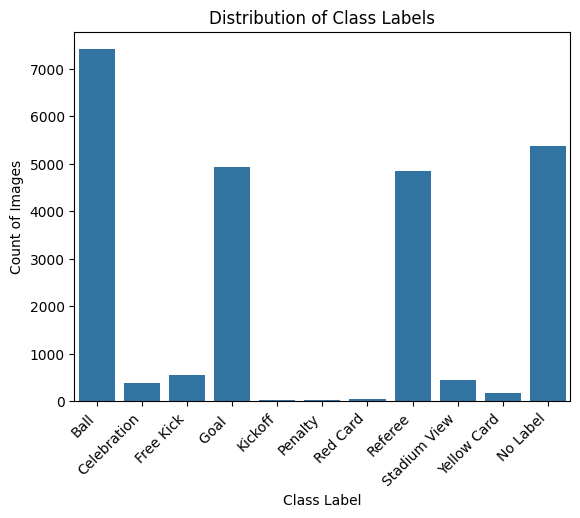

In [12]:
# Visualize label counts
sns.barplot(x=label_counts.keys(), y=label_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Count of Images")
plt.title("Distribution of Class Labels")
plt.xticks(rotation=45, ha="right")
plt.show()

### Cleaning Images

Remove unlabeled entries. The initial belief was that these images would not be useful for training the model. However, we may need to consider that it is necessary to train the model on what images do not contain items of interest. The removed group of no label images may need to be added back in as we progress with building, training, and refining the models.

In [13]:
# Remove images with empty label lists
image_data = {key: value for key, value in image_data.items() if value[0]}  

In [14]:
# Observe image count reduction
print(f"Original image count: {len(image_paths)}\nLabeled image count: {len(image_data)}")

Original image count: 16247
Labeled image count: 10866


Recount labels

In [15]:
# Flatten all label lists into a single list
all_labels = [label for labels in image_data.values() for label in labels[0]]
# Count occurrences of each label
label_counts = Counter(all_labels)
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[0])) # sort the labels alphabetically for consistency when comparing with the split train/test sets later
# Print label frequency
all_count = 0
for label, count in label_counts.items():
    print(f"{label}: {count}")
    all_count = all_count + count
print(f"Total labels assigned: {all_count}")

Ball: 7411
Celebration: 397
Free Kick: 550
Goal : 4934
Kickoff: 40
Penalty: 22
Red Card: 53
Referee: 4853
Stadium View: 452
Yellow Card: 179
Total labels assigned: 18891


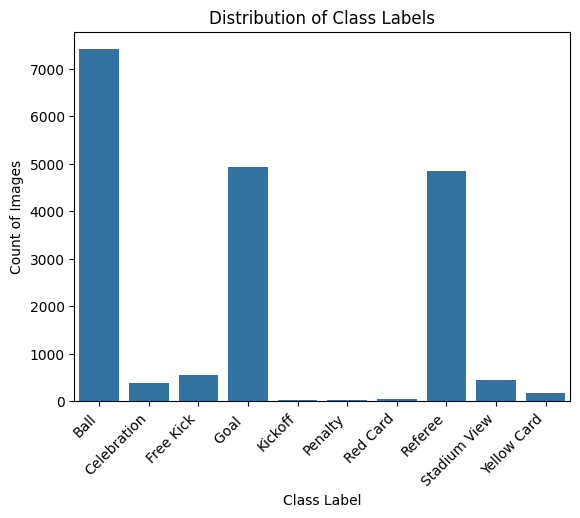

In [16]:
# Visualize label counts
sns.barplot(x=label_counts.keys(), y=label_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Count of Images")
plt.title("Distribution of Class Labels")
plt.xticks(rotation=45, ha="right")
plt.show()

# Data Prep for Modeling

## Extract images and labels as input and target features

In [17]:
%%time
# Extract images and labels from dictionary into separate variables
X = np.array([data[1] for data in image_data.values()])  # Array of images
y = [data[0] for data in image_data.values()]  # list of labels


CPU times: total: 1min 14s
Wall time: 2min 6s


In [18]:
print("X shape:", X.shape)  # check shape of the X array which should be (num_samples, img_dim, img_dim, 3)
print("Example y:", y[random.randint(0, len(y)-1)]) # check label format

X shape: (10866, 224, 224, 3)
Example y: ['Ball', 'Referee']


In [19]:
# Create indices to use to reconnect train and test sets back to the full set
X_indices = np.arange(len(X))
y_indices = np.arange(len(y))

## Create train and test datasets

In [20]:
# Prepare to split into train and test datasets for modeling
from sklearn.model_selection import train_test_split # import necesary library
test_size = 0.20 # global test size variable
random_state = 20256165 # set global random state variable

In [21]:
%%time
# Split the indices. Perform train/test split on the X_indices then set the y indices equal to resulting split to ensure the same items are used
X_indices_train, X_indices_test, y_indices_train, y_indices_test, X_train, X_test, y_train, y_test = train_test_split(X_indices, y_indices, X, y, test_size=test_size, random_state=random_state) 

CPU times: total: 52.6 s
Wall time: 1min 51s


In [22]:
print("X_train shape:", X_train.shape)  # check shape of the train X array which should be (num_samples, img_dim, img_dim, 3)
print("X_test shape:", X_test.shape)  # check shape of the test X array which should be (num_samples, img_dim, img_dim, 3)
print("y_train length:", len(y_train)) # check train label length
print("y_test length:", len(y_test)) # check test label length

X_train shape: (8692, 224, 224, 3)
X_test shape: (2174, 224, 224, 3)
y_train length: 8692
y_test length: 2174


## Count and visualize the class distribution between train and test sets

In [23]:
# Flatten all train label lists into a single list
train_labels = [label for labels in y_train for label in labels]
# Count occurrences of each label
train_counts = Counter(train_labels)
train_counts = dict(sorted(train_counts.items(), key=lambda item: item[0])) # sort the labels alphabetically so the train and test sets line up for comparison
# Print label frequency
all_count = 0
for label, count in train_counts.items():
    print(f"{label}: {count}")
    all_count = all_count + count
print(f"Train labels assigned: {all_count}")

Ball: 5937
Celebration: 310
Free Kick: 458
Goal : 3976
Kickoff: 36
Penalty: 19
Red Card: 39
Referee: 3870
Stadium View: 361
Yellow Card: 132
Train labels assigned: 15138


In [24]:
# Flatten all test label lists into a single list
train_labels = [label for labels in y_test for label in labels]
# Count occurrences of each label
test_counts = Counter(train_labels)
test_counts = dict(sorted(test_counts.items(), key=lambda item: item[0])) # sort the labels alphabetically so the train and test sets line up for comparison
# Print label frequency
all_count = 0
for label, count in test_counts.items():
    print(f"{label}: {count}")
    all_count = all_count + count
print(f"Test labels assigned: {all_count}")

Ball: 1474
Celebration: 87
Free Kick: 92
Goal : 958
Kickoff: 4
Penalty: 3
Red Card: 14
Referee: 983
Stadium View: 91
Yellow Card: 47
Test labels assigned: 3753


In [25]:
# Combine train and test counts into a single dataframe
counts_df = pd.DataFrame({"Class": train_counts.keys(), "Train": train_counts.values(), "Test": test_counts.values()})
print(counts_df)
counts_df = counts_df.melt(id_vars="Class", var_name="Dataset", value_name="Count")

          Class  Train  Test
0          Ball   5937  1474
1   Celebration    310    87
2     Free Kick    458    92
3         Goal    3976   958
4       Kickoff     36     4
5       Penalty     19     3
6      Red Card     39    14
7       Referee   3870   983
8  Stadium View    361    91
9   Yellow Card    132    47


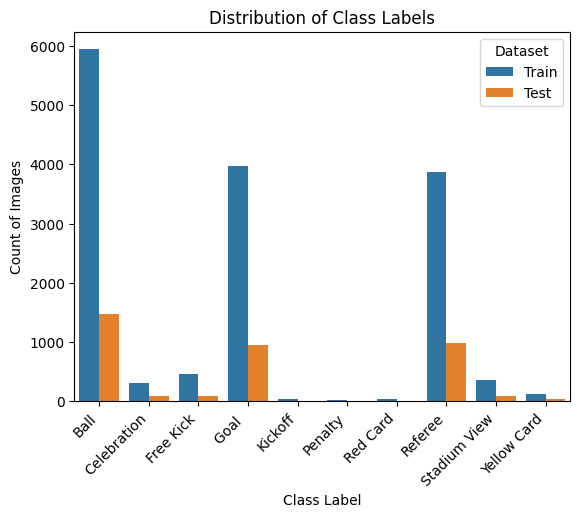

In [26]:
# Visualize label counts
sns.barplot(data=counts_df, x="Class", y="Count", hue="Dataset", dodge=True)
plt.xlabel("Class Label")
plt.ylabel("Count of Images")
plt.title("Distribution of Class Labels")
plt.xticks(rotation=45, ha="right")
plt.show()

## Visualize some images to confirm successful prep

In [27]:
# Define function to show an image where x is an image
def show_img(x, title="", bot=""):
    plt.imshow(x)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel(bot)
    plt.title(title)
    plt.plot()

In [28]:
# Define function to show some number of images where X is an array of images, y is an array of labels, and n_images is the number of images to be displayed
import math
def display_images(X, y, index, n_images):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j=0
    for i in random.sample(range(len(X)), n_images):
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(X[i], title=", ".join(label.strip() for label in y[i]), bot=f"Image {list(image_data.keys())[index[i]]}") # Note, the image # is from the image dictionary and comes from the filename in the original dataset
        plt.plot()
        j += 1
    plt.tight_layout()

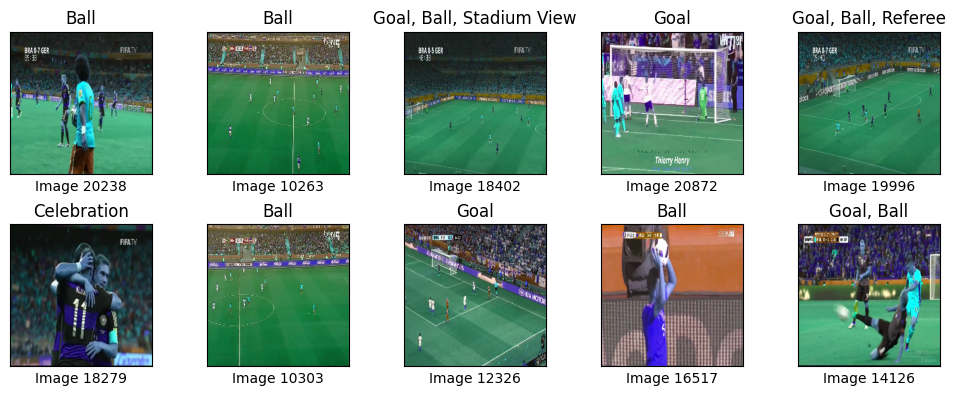

In [29]:
# Preview Train data
# Set the number images to preview
n_images_train = 10
# Show the images
display_images(X_train, y_train, X_indices_train, n_images_train)

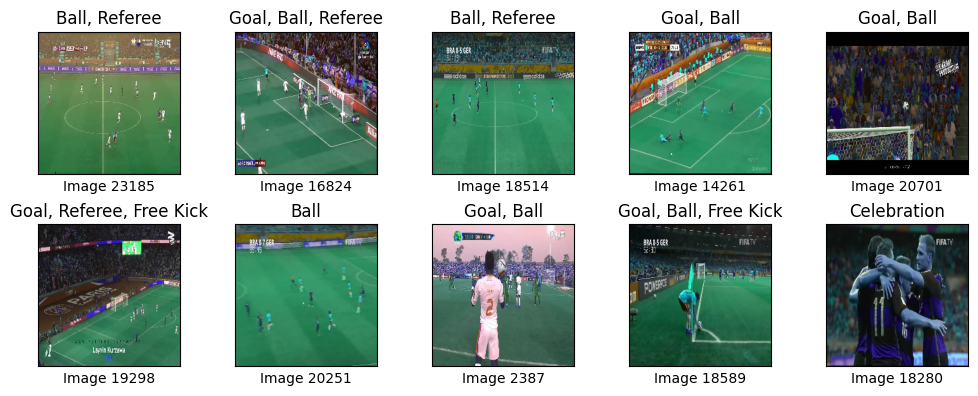

In [30]:
# Preview Test data
# Set the number images to preview
n_images_test = 10
# Show the images
display_images(X_test, y_test, X_indices_test, n_images_test)